In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.models import Model
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from utility_db_outliers import load_dataset

from utility import calculate_input_gradients, perturb_inputs, preprocess_images, \
                    postprocess_features, save_data_hdf5,get_dataset_hdf5,\
                    build_one_class_svm, combine_inliners_outliers, apply_temp_scale_to_model,\
                    apply_log_temp_scale_to_model, perturb_inputs_odin, extract_layer_features

from models_lib import load_custom_model_for_ds
import h5py

from general_setting import *
import time

import scipy.io as sio
import matplotlib.lines as mlines

In [3]:
BATCH_SIZE = 100
SAVE_RESULTS = True
id_name=ID_DS_LIST[0] # selects the ID dataset.
id_model=ID_MODEL_LIST[0]  # select the deep model used for training ID dataset.
print(id_name,id_model)

MNIST LeNet


In [4]:
(org_traing_data, org_training_labels),(id_eva_data,y_test)  = load_dataset(id_name)

org_traing_data_processed = preprocess_images(id_name, org_traing_data, id_model, verbose=True)
id_eva_data_processed = preprocess_images(id_name, id_eva_data, id_model, verbose=True)

Preprocessing is not needed.
Preprocessing is not needed.


In [5]:
x_test = id_eva_data_processed
y_test = to_categorical(y_test, 10)
org_model = load_custom_model_for_ds(id_name, id_model)
# org_model.summary()
sc = org_model.evaluate(x_test,y_test)
print(sc)

The weights of LeNet model was loaded.
10000/10000 [==============================] - 1s 142us/step
[0.02577948803557374, 0.992]


In [6]:
model = org_model

In [7]:
def combine_inliners_outliers(inliers, outliers, i_label=1, o_label=0, verbose=True):
    temp_outliers = outliers
    temp_inliers = inliers
    if i_label == 1:
        i_labels = np.ones(temp_inliers.shape[0])
    else:
        i_labels = np.zeros(temp_inliers.shape[0])

    if o_label == 0:
        o_labels = np.zeros(temp_outliers.shape[0])
    else:
        o_labels = np.ones(temp_outliers.shape[0])

    mixed_labels = np.append(i_labels, o_labels)
    mixed_data = np.vstack((temp_inliers, temp_outliers))
    return mixed_data, mixed_labels

In [8]:
def extract_layer_features(in_model, in_data, in_layer, in_batch_size, shorten_model=False):
    for i_d in range(in_data.shape[0] // in_batch_size):
        batch_data = in_data[i_d * in_batch_size:(i_d + 1) * in_batch_size]

        if shorten_model == False:
            batch_features = extract_features(in_model, batch_data, in_layer)
        else:
            batch_features = in_model.predict(batch_data)
        
#         print(batch_features)
           
        batch_features_processed = postprocess_features(batch_features)
        if i_d == 0:
            features = batch_features_processed
        else:
            features = np.vstack((features, batch_features_processed))

    if (i_d + 1) * in_batch_size < in_data.shape[0]:
        batch_data = in_data[(i_d + 1) * in_batch_size:in_data.shape[0]]

        if shorten_model == False:
            batch_features = extract_features(in_model, batch_data, in_layer)
        else:
            batch_features = in_model.predict(batch_data)

        batch_features_processed = postprocess_features(batch_features)
        if i_d == 0:
            features = batch_features_processed
        else:
            features = np.vstack((features, batch_features_processed))

    return features

In [9]:
def extract_features(in_model, in_img_perturbed, in_layer_inx):
    l = in_model.layers[in_layer_inx]
    aux_model = Model(inputs=in_model.input, outputs=l.output)
    return aux_model.predict(in_img_perturbed)

In [10]:
def postprocess_features(in_features):
    if len(in_features.shape) == 4:
        output = np.sum(in_features, axis=(1, 2))
    if len(in_features.shape) == 2:
        output = in_features
    return output

In [11]:
layer_inx = 0
batch_size = 256
tmp_l=model.layers[layer_inx]
feature_model = Model(inputs=model.input, outputs=tmp_l.output)

In [15]:
ood_ds_name = 'FASHION_MNIST'
(_,_),(ood_eva_data,_) = load_dataset(ood_ds_name)
ood_eva_data_processed  = preprocess_images(id_name, ood_eva_data, id_model, verbose=True)
mixed_data, mixed_labels = combine_inliners_outliers(id_eva_data_processed,ood_eva_data_processed)
mixed_labels = mixed_labels.astype(int)

Preprocessing is not needed.


In [13]:
ds_name = 'FASHION_MNIST'
ood = id_name+"_"+id_model+"_"+ ds_name
ood_images = np.load('classdatas_ood/'+ood+'.npy',allow_pickle=True)
testimgs = np.load('classdatas_id/testimgs_%s_%s.npy'%(id_model,id_name),allow_pickle=True)
# mixed_data, mixed_labels = combine_inliners_outliers(np.asarray(testimgs[0]),np.asarray(ood_images[0]))
# mixed_labels = mixed_labels.astype(int)

In [16]:
features = extract_layer_features(feature_model,mixed_data,layer_inx,batch_size,\
                                  shorten_model=True )

In [17]:
reducer = umap.UMAP(random_state=42,min_dist=0.8)
embedding = reducer.fit_transform(features)

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


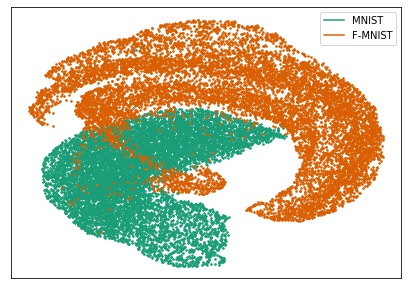

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
# sns.set(context="paper", style="white")

lens0 = id_eva_data_processed.shape[0]
lens1 = mixed_data.shape[0]
plt.scatter(embedding[:lens0, 0], embedding[:lens0, 1], c='#1b9e77', cmap="Spectral", s=2.5)
plt.scatter(embedding[lens0:lens1, 0], embedding[lens0:lens1, 1], c = '#d95f02', cmap="Spectral", s=2.5)

plt.setp(ax, xticks=[], yticks=[])
id_line = mlines.Line2D([], [], color='#1b9e77', markersize=15, label='MNIST')
ood_line1 = mlines.Line2D([], [], color='#d95f02', markersize=15, label='F-MNIST')
plt.legend(handles=[id_line,ood_line1], loc="up right")
plt.savefig('fmnist00.svg')
plt.show()

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


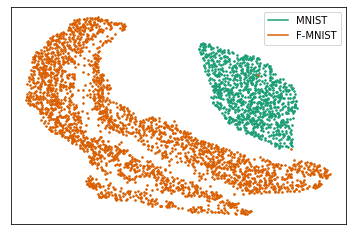

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


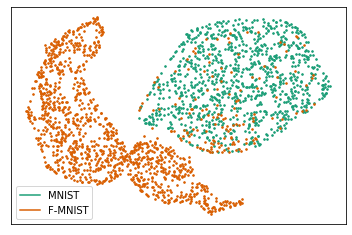

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


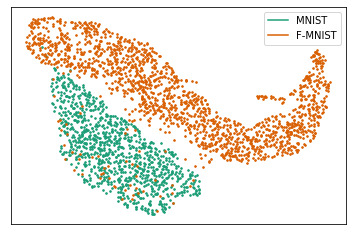

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


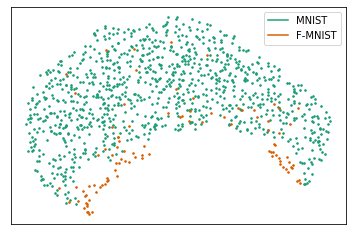

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


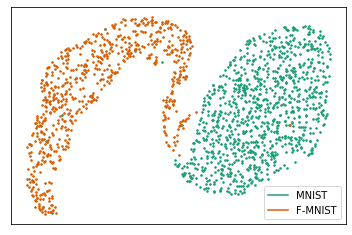

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


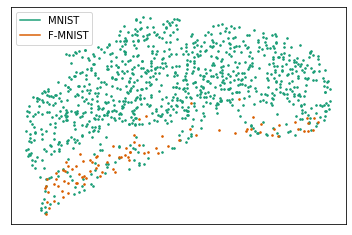

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


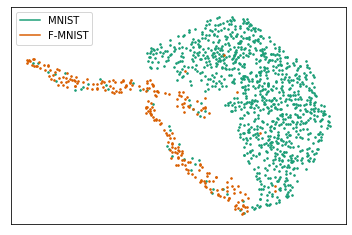

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


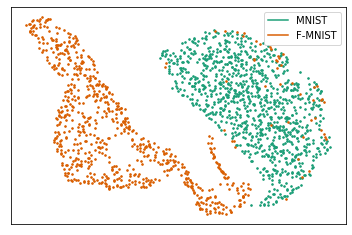

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


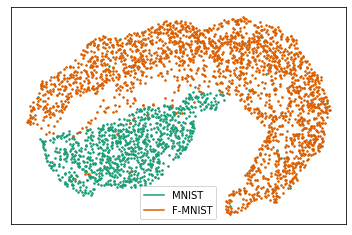

D:\software\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


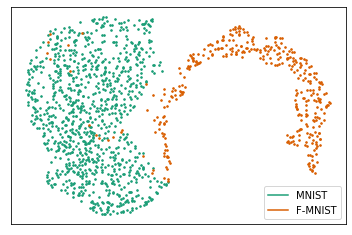

In [14]:
# fig, ax = plt.subplots(figsize=(7, 5))
for i in range(10):
    mixed_data, mixed_labels = combine_inliners_outliers(np.asarray(testimgs[i]),np.asarray(ood_images[i]))
    mixed_labels = mixed_labels.astype(int)
    features = extract_layer_features(feature_model,mixed_data,layer_inx,batch_size,\
                                  shorten_model=True )
    reducer = umap.UMAP(random_state=42,min_dist=0.8)
    embedding = reducer.fit_transform(features)
    lens0 = np.asarray(testimgs[0]).shape[0]
    lens1 = mixed_data.shape[0]
    plt.scatter(embedding[:lens0, 0], embedding[:lens0, 1], c='#1b9e77', cmap="Spectral", s=2.5)
    plt.scatter(embedding[lens0:lens1, 0], embedding[lens0:lens1, 1], c = '#d95f02', cmap="Spectral", s=2.5)

    plt.xticks([])
    plt.yticks([])
    id_line = mlines.Line2D([], [], color='#1b9e77', markersize=15, label='MNIST')
    ood_line1 = mlines.Line2D([], [], color='#d95f02', markersize=15, label='F-MNIST')
    plt.legend(handles=[id_line,ood_line1], loc="up right")
    plt.savefig('fmnist%s.svg'%(i))
    plt.show()